In [1]:
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd

# Data Prep

Load in mat file for subject_00 and get the positions for when eyes are closed and open.

In [2]:
patient00_raw = scipy.io.loadmat("alpha-wave-testing/data/subject_00.mat")["SIGNAL"]
print(patient00_raw.shape)

begin_eyes_closed = np.where(patient00_raw[:, 17] == 1)[0]
begin_eyes_open = np.where(patient00_raw[:, 18] == 1)[0]
print(begin_eyes_closed)
print(begin_eyes_open)

eyes_closed_positions = np.array([[begin_eyes_closed[0], begin_eyes_open[0]-1]]) # inclusive
for i in range(1, len(begin_eyes_closed)):
    eyes_closed_positions = np.append(eyes_closed_positions, [[begin_eyes_closed[i], begin_eyes_open[i]-1]], axis=0)

eyes_open_positions = np.array([[begin_eyes_open[0], begin_eyes_closed[1]-1]]) # inclusive
for i in range(2, len(begin_eyes_open)):
    eyes_open_positions = np.append(eyes_open_positions, [[begin_eyes_open[i-1], begin_eyes_closed[i]-1]], axis=0)
eyes_open_positions = np.append(eyes_open_positions, [[begin_eyes_open[-1], patient00_raw.shape[0]-1]], axis=0)

(63104, 19)
[ 8351 19460 31435 41698 51722]
[13864 25677 36685 46900 56838]


In [3]:
start = eyes_closed_positions[0,0]
end = eyes_closed_positions[0,1] + 1 # my data is inclusive
print("[{}, {})".format(start, end))
eyes_closed_data = np.array(patient00_raw[start:end, 1:17]) # Get the eyes closed electrode data
for start, end in eyes_closed_positions[1:]:
    end = end + 1
    print("[{}, {})".format(start, end))
    eyes_closed_data = np.append(eyes_closed_data, patient00_raw[start:end, 1:17], axis=0) # Get the eyes closed electrode data
print("eyes_closed_data.shape:", eyes_closed_data.shape)

start = eyes_open_positions[0,0]
end = eyes_open_positions[0,1] + 1 # my data is inclusive
print("[{}, {})".format(start, end))
eyes_open_data = np.array(patient00_raw[start:end, 1:17]) # Get the eyes closed electrode data
for start, end in eyes_open_positions[1:]:
    end = end + 1
    print("[{}, {})".format(start, end))
    eyes_open_data = np.append(eyes_open_data, patient00_raw[start:end, 1:17], axis=0) # Get the eyes closed electrode data
print("eyes_open_data.shape:", eyes_open_data.shape)

[8351, 13864)
[19460, 25677)
[31435, 36685)
[41698, 46900)
[51722, 56838)
eyes_closed_data.shape: (27298, 16)
[13864, 19460)
[25677, 31435)
[36685, 41698)
[46900, 51722)
[56838, 63104)
eyes_open_data.shape: (27455, 16)


Positions that eyes are closed:
8351 -> 13863
19460 -> 25676
31435 -> 36684
41698 -> 46899
51722 -> 56837

Positions that eyes are open:
13864 -> 19459
25677 -> 31434
36685 -> 41697
46900 -> 51721
56838 -> 63103

Eyes Closed means and stds:
Electrode 0 mean: 2393.1625859863984	std: 102.37631438912304
Electrode 1 mean: -2249.199355238864	std: 78.46947809696026
Electrode 2 mean: 533.4685234826966	std: 69.95080481148267
Electrode 3 mean: -6726.559007355945	std: 67.53860757741114
Electrode 4 mean: -6250.405872854165	std: 85.96307594809424
Electrode 5 mean: -11399.557228425892	std: 99.62630416892577
Electrode 6 mean: -2556.808311162763	std: 108.94293391521614
Electrode 7 mean: -13934.866184352628	std: 34.85244377232378
Electrode 8 mean: -1780.5565228617702	std: 62.990025752559724
Electrode 9 mean: -3743.1278419263463	std: 121.28484972560838
Electrode 10 mean: -5968.0263076087185	std: 135.42210672076934
Electrode 11 mean: -12295.482942705474	std: 35.45499566468557
Electrode 12 mean: -7241.52

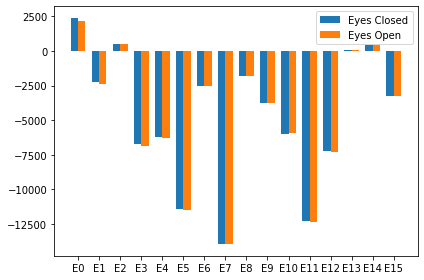

In [4]:
# Find the means and standard deviations per electrode and display.
# Note: this is just for visualization of the data; won't be used for model
eyes_closed_means = np.mean(eyes_closed_data, axis=0)
eyes_closed_stds = np.std(eyes_closed_data, axis=0)

eyes_open_means = np.mean(eyes_open_data, axis=0)
eyes_open_stds = np.std(eyes_open_data, axis=0)

print("Positions that eyes are closed:")
for start, end in eyes_closed_positions:
    print(start, "->", end)
print()
print("Positions that eyes are open:")
for start, end in eyes_open_positions:
    print(start, "->", end)
print()

print("Eyes Closed means and stds:")
for i in range(len(eyes_closed_means)):
    print("Electrode {} mean: {}\tstd: {}".format(i, eyes_closed_means[i], eyes_closed_stds[i]))
print()

print("Eyes Open means and stds:")
for i in range(len(eyes_open_means)):
    print("Electrode {} mean: {}\tstd: {}".format(i, eyes_open_means[i], eyes_open_stds[i]))
print()

labels = ["E"+str(i) for i in range(16)]
x = np.arange(len(labels))
width=0.35

fig, ax = plt.subplots()
rects_eyes_closed = ax.bar(x-width/2, eyes_closed_means, width, label="Eyes Closed")
rects_eyes_open = ax.bar(x+width/2, eyes_open_means, width, label="Eyes Open")

plt.rcParams['figure.figsize'] = [15, 10] # https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

In [5]:
# Label times when eyes are closed with 0 and times when eyes are open with 1
eyes_closed_labels = np.zeros(eyes_closed_data.shape[0])
eyes_open_labels = np.ones(eyes_open_data.shape[0]) # open is 1
eyes_data = np.concatenate([eyes_closed_data, eyes_open_data])
eyes_labels = np.concatenate([eyes_closed_labels, eyes_open_labels])

eyes_data_means = np.mean(eyes_data, axis=0)
eyes_data_stds = np.std(eyes_data, axis=0)

print(eyes_data_means)
print(eyes_data_stds)
print()
normalized_eyes_data = np.subtract(eyes_data, eyes_data_means)
normalized_eyes_data = np.divide(normalized_eyes_data, eyes_data_stds)
print(np.mean(normalized_eyes_data, axis=0)) # should now see centered around 0 w/ std dev about 1 per electrode. This will help when training model
print(np.std(normalized_eyes_data, axis=0))
print(normalized_eyes_data.shape)

[  2285.26091573  -2326.53717406    512.18594951  -6782.56613112
  -6266.99097788 -11438.22928655  -2560.04016667 -13953.185485
  -1805.6646143   -3735.5743914   -5961.31835667 -12305.88180085
  -7259.02945031     47.7699864     444.22085228  -3235.79015046]
[146.29751199 107.45668447  70.93212913  96.34319735  83.60274292
 106.55163222 100.06285958  39.65261293  74.1709095  120.44000388
 134.03463383  34.17907767  34.67076406  36.00594493  48.23664714
  33.35206823]

[ 1.02987364e-15  4.04474567e-15  1.11292797e-15  2.98995573e-16
  9.38513883e-16 -9.36852797e-15 -9.38513883e-16  1.95156902e-14
  2.25907767e-15  5.31547686e-16 -6.97656338e-16 -8.38848692e-15
 -1.36873529e-14  1.66108652e-17  6.97656338e-16  3.02317746e-15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(54753, 16)


In [6]:
# Shuffle the data
pd_normalized_eyes_data = pd.DataFrame(normalized_eyes_data)
pd_normalized_eyes_data["Labels"] = eyes_labels
pd_normalized_eyes_data["Labels"] = pd_normalized_eyes_data["Labels"].astype("int")
pd_normalized_eyes_data = pd_normalized_eyes_data.sample(frac=1)
pd_normalized_eyes_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,Labels
53713,-2.302892,-0.833702,-0.667748,-2.742857,0.310986,-2.115146,0.022189,0.096171,-2.641356,0.913593,0.753158,-1.863663,-1.968428,-1.737721,-0.409561,-0.776111,1
9018,1.081946,0.893079,-0.247972,1.232661,-0.581722,1.087847,-0.465234,-0.505810,0.656635,-0.416120,-0.603017,1.193449,1.987436,0.073564,-0.739777,0.655526,0
14341,1.050047,1.143473,1.313389,1.449400,1.055690,0.440833,0.648117,-0.083490,0.597131,0.081305,0.286693,0.995988,-0.102748,-0.746236,-0.477934,-0.495509,0
44903,-0.881544,-0.568338,0.205405,-0.803800,0.305414,-0.997043,0.851387,-0.454855,-0.538912,0.821949,0.889051,-0.327778,-0.055019,0.362068,0.671538,0.919365,1
20890,0.582537,1.209634,1.426054,0.588084,1.411177,-0.182040,1.145790,2.509315,0.068882,1.145575,1.240872,1.933719,0.923409,1.117055,1.725678,2.070861,0


In [7]:
# Split into train/val/test
df_train_data = pd_normalized_eyes_data.iloc[0:int(0.7 * len(pd_normalized_eyes_data))]
df_val_data = pd_normalized_eyes_data.iloc[int(0.7 * len(pd_normalized_eyes_data)): int(0.85 * len(pd_normalized_eyes_data))]
df_test_data = pd_normalized_eyes_data.iloc[int(0.85 * len(pd_normalized_eyes_data)):]
print(df_train_data.shape, df_val_data.shape, df_test_data.shape)

train_data = df_train_data.iloc[:, 0:16].copy().to_numpy()
train_labels = df_train_data["Labels"].copy().to_numpy()

val_data = df_val_data.iloc[:, 0:16].copy().to_numpy()
val_labels = df_val_data["Labels"].copy().to_numpy()

test_data = df_test_data.iloc[:, 0:16].copy().to_numpy()
test_labels = df_test_data["Labels"].copy().to_numpy()

print(train_data.shape, val_data.shape, test_data.shape)
print(train_labels.shape, val_labels.shape, test_labels.shape)

(38327, 17) (8213, 17) (8213, 17)
(38327, 16) (8213, 16) (8213, 16)
(38327,) (8213,) (8213,)


# Build and Train Model

In [8]:
# This is our model. To understand what each line means, see https://www.tensorflow.org/guide/keras/functional
def get_model(input_shape):
    x_input = Input(input_shape)
    x = Dense(32, activation="relu")(x_input)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=x_input, outputs=x)
    return model

In [9]:
model = get_model(train_data.shape[1]) # create an instance of the model

In [10]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Before fitting, we have to compile the model with an optimizer (how the network adjusts the weights), loss function (what the model is
# optimized to), and any metrics we are interested in.
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)])

In [12]:
# Fit the model! (You can run this; this is such a small model that it only took like 10 seconds on my CPU)
history = model.fit(x=train_data,
                    y=train_labels,
                    validation_data=(val_data, val_labels),
                    batch_size=32,
                    epochs=15)

Epoch 1/15
1198/1198 [==============================] - 1s 736us/step - loss: 0.2805 - binary_accuracy: 0.8889 - val_loss: 0.2162 - val_binary_accuracy: 0.9078
Epoch 2/15
1198/1198 [==============================] - 1s 574us/step - loss: 0.1806 - binary_accuracy: 0.9181 - val_loss: 0.1480 - val_binary_accuracy: 0.9318
Epoch 3/15
1198/1198 [==============================] - 1s 577us/step - loss: 0.1268 - binary_accuracy: 0.9469 - val_loss: 0.1100 - val_binary_accuracy: 0.9586
Epoch 4/15
1198/1198 [==============================] - 1s 592us/step - loss: 0.0989 - binary_accuracy: 0.9638 - val_loss: 0.0913 - val_binary_accuracy: 0.9683
Epoch 5/15
1198/1198 [==============================] - 1s 625us/step - loss: 0.0848 - binary_accuracy: 0.9697 - val_loss: 0.0811 - val_binary_accuracy: 0.9696
Epoch 6/15
1198/1198 [==============================] - 1s 565us/step - loss: 0.0761 - binary_accuracy: 0.9719 - val_loss: 0.0736 - val_binary_accuracy: 0.9718
Epoch 7/15
1198/1198 [==================

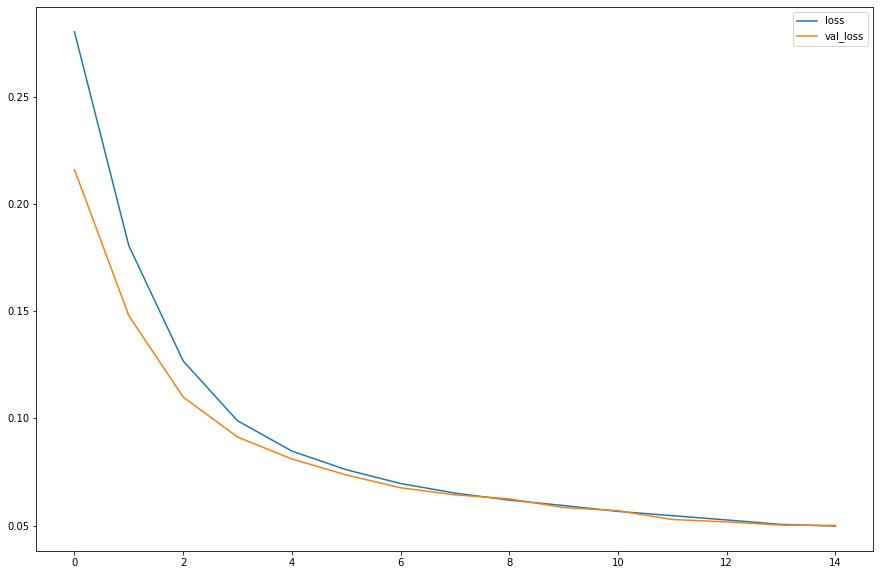

In [13]:
# See how the loss and validation loss change over time
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(loss)
plt.plot(val_loss)
plt.legend(["loss","val_loss"]);

In [14]:
# Only evaluate your model on the test data after creating the final model. Normally, there are many iterations
# in improving hyperparameters and model architectures. The validation set is what you want to optimize to for that.
# The point of the separate test set is to get a final metric on how the model will perform on completely new data
# that the model has never trained on nor been optimized to (i.e. give you an understanding of "real world" performance.
model.evaluate(x=test_data, y=test_labels)

257/257 [==============================] - 0s 444us/step - loss: 0.0507 - binary_accuracy: 0.9792


[0.05074014887213707, 0.979179322719574]

In [15]:
# How you can save the model
model.save?

Signature:
model.save(
    filepath,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
)
Docstring:
Saves the model to Tensorflow SavedModel or a single HDF5 file.

The savefile includes:

- The model architecture, allowing to re-instantiate the model.
- The model weights.
- The state of the optimizer, allowing to resume training
    exactly where you left off.

This allows you to save the entirety of the state of a model
in a single file.

Saved models can be reinstantiated via `keras.models.load_model`.
The model returned by `load_model` is a compiled model ready to be used
(unless the saved model was never compiled in the first place).

Models built with the Sequential and Functional API can be saved to both the
HDF5 and SavedModel formats. Subclassed models can only be saved with the
SavedModel format.

Note that the model weights may have different scoped names after being
loaded. Scoped names include the model/layer names

In [16]:
# How you can save just the weights
model.save_weights?

Signature:
model.save_weights(
    filepath,
    overwrite=True,
    save_format=None,
    options=None,
)
Docstring:
Saves all layer weights.

Either saves in HDF5 or in TensorFlow format based on the `save_format`
argument.

When saving in HDF5 format, the weight file has:
  - `layer_names` (attribute), a list of strings
      (ordered names of model layers).
  - For every layer, a `group` named `layer.name`
      - For every such layer group, a group attribute `weight_names`,
          a list of strings
          (ordered names of weights tensor of the layer).
      - For every weight in the layer, a dataset
          storing the weight value, named after the weight tensor.

When saving in TensorFlow format, all objects referenced by the network are
saved in the same format as `tf.train.Checkpoint`, including any `Layer`
instances or `Optimizer` instances assigned to object attributes. For
networks constructed from inputs and outputs using `tf.keras.Model(inputs,
outputs)`, `Layer` 